# Using Specific Libraries for Specific Use Cases

## Use Case : Statsmodels & Sklearn for Hidden Volatility Modelling in Finance

### Citation
<b>Sector Rotation in Times of Crises</b>
<br>Pratiksha Sharma, Dhruvi Nishar, Vedant Kabra, Peyasha Sehgal, Debashis Guha, Larry Pohlman
<br>The Journal of Portfolio Management Jun 2022, 48 (7) 59-74; DOI: 10.3905/jpm.2022.1.379

Note: The work below is based off of the ideas on the paper cited above & is not an exact replication of the final results/techniques used in the same

## Statsmodels : Markov Regression

### Step 1: Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import seaborn as sns

### Step 2: Document Date & Time you ran a process

In [2]:
from datetime import date
from datetime import datetime

today = date.today()
d = today.strftime("%B %d, %Y")
print("Model run on: ",d)
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time, "EST")

Model run on:  December 05, 2022
Current Time = 12:33:16 EST


### Step 3: Importing Data

In [3]:
closing = pd.read_csv("ETFData.csv")
# closing.info()
closing.Date = pd.to_datetime(closing.Date,format="%d-%m-%Y")
closing = closing.set_index("Date")
closing

,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
Date,,,,,,,,,
1998-12-22,12.81,14.37,9.50,15.75,24.93,16.27,13.91,18.41,19.65
1998-12-23,12.95,14.67,9.64,16.02,25.54,16.65,13.86,18.82,19.72
1998-12-24,13.24,14.59,9.71,16.22,25.44,16.64,14.11,18.94,20.09
1998-12-28,13.13,14.51,9.59,16.33,25.51,16.54,14.04,18.66,19.91
1998-12-29,13.37,14.66,9.68,16.55,25.57,16.90,14.28,19.08,20.35
...,...,...,...,...,...,...,...,...,...
2020-12-24,71.58,38.12,28.95,88.00,129.06,66.72,61.21,111.47,157.88
2020-12-28,71.30,37.88,29.09,88.11,130.52,67.25,61.48,111.75,159.68
2020-12-29,71.13,37.63,28.99,87.58,129.90,67.05,61.47,112.28,159.73


In [4]:
closing.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5534 entries, 1998-12-22 to 2020-12-31
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   XLB     5534 non-null   float64
 1   XLE     5534 non-null   float64
 2   XLF     5534 non-null   float64
 3   XLI     5534 non-null   float64
 4   XLK     5534 non-null   float64
 5   XLP     5534 non-null   float64
 6   XLU     5534 non-null   float64
 7   XLV     5534 non-null   float64
 8   XLY     5534 non-null   float64
dtypes: float64(9)
memory usage: 432.3 KB


### Step 4: Plot some prelimnary data to get an idea of what you are working with

In [5]:
closing.columns

Index(['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY'], dtype='object')

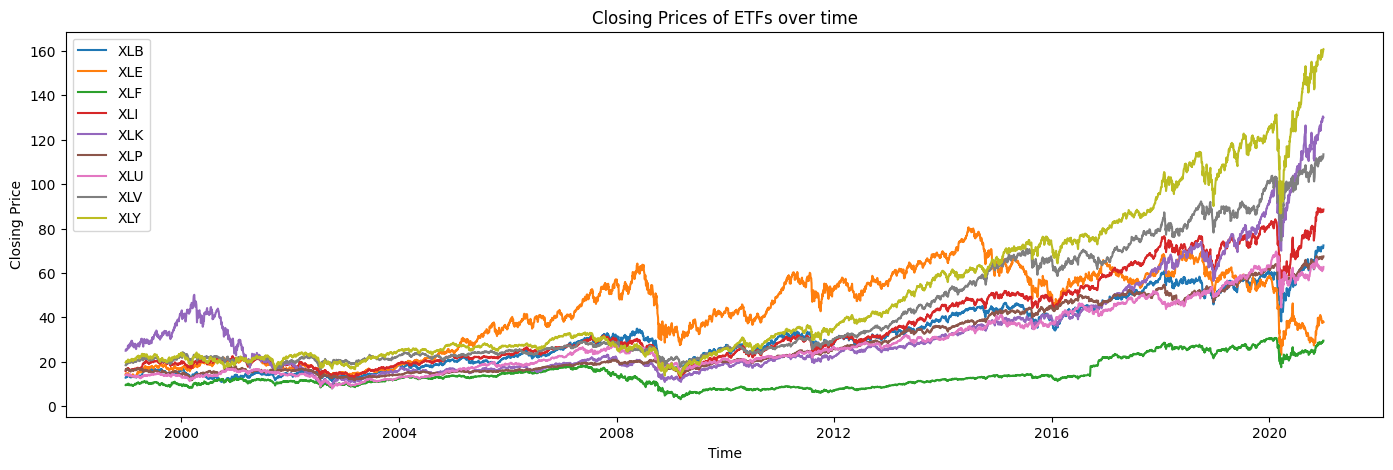

In [6]:
plt.figure(figsize=(17,5))
plt.plot(closing, label = closing.columns)
plt.legend()
plt.title("Closing Prices of ETFs over time")
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.show()

### Step 5: Data Preprocessing - Calculating Percentage Change

In the domain of finance, we call this type of converision as 'calculation of returns'.

In [7]:
c2cl=closing.pct_change().apply(lambda x: np.log(1+x))
# print(c2cl.head())
# print(c2cl.info())
c2cl=c2cl.dropna()
c2cl.describe()

,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
count,5533.000000,5533.000000,5533.000000,5533.000000,5533.000000,5533.000000,5533.000000,5533.000000,5533.000000
mean,0.000313,0.000175,0.000205,0.000312,0.000299,0.000257,0.000272,0.000329,0.000380
std,0.015578,0.018400,0.019280,0.013881,0.016460,0.009948,0.012479,0.011812,0.014188
min,-0.122097,-0.224790,-0.181061,-0.121325,-0.148779,-0.098325,-0.120678,-0.104669,-0.134052
25%,-0.007057,-0.008354,-0.007194,-0.005755,-0.006473,-0.004282,-0.005525,-0.005166,-0.005750
50%,0.000676,0.000509,0.000610,0.000714,0.001010,0.000511,0.000915,0.000654,0.000791
75%,0.008199,0.009537,0.007843,0.007053,0.007658,0.005161,0.006591,0.006312,0.007253
max,0.114884,0.184762,0.267963,0.120230,0.158256,0.089292,0.118911,0.123124,0.120370


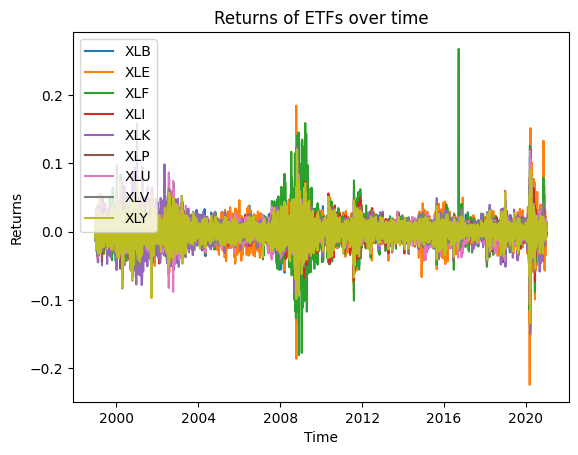

In [8]:
# plt.figure(figsize=(17,3))
plt.plot(c2cl, label = closing.columns)
plt.legend()
plt.title("Returns of ETFs over time")
plt.xlabel('Time')
plt.ylabel('Returns')
plt.show()

<b>Notice something while plotting?</b>

<br>There are spikes around 2016 in XLF. This is worth further investigation. 

In [9]:
# masking & filtering

# print(closing.index.year)
# print(closing.index.month)
# try print(closing.index.day)

closing.XLF[closing.index.year == 2016]

Date
2016-01-04    13.35
2016-01-05    13.39
2016-01-06    13.19
2016-01-07    12.82
2016-01-08    12.61
              ...  
2016-12-23    21.98
2016-12-27    22.01
2016-12-28    21.79
2016-12-29    21.63
2016-12-30    21.69
Name: XLF, Length: 252, dtype: float64

Date
2016-09-01    14.10
2016-09-02    14.18
2016-09-06    14.15
2016-09-07    14.14
2016-09-08    14.13
2016-09-09    13.87
2016-09-12    14.02
2016-09-13    13.77
2016-09-14    13.74
2016-09-15    13.82
2016-09-16    13.70
2016-09-19    17.91
2016-09-20    17.93
2016-09-21    18.05
2016-09-22    18.09
2016-09-23    17.98
2016-09-26    17.70
2016-09-27    17.84
2016-09-28    17.93
2016-09-29    17.67
2016-09-30    17.92
2016-10-03    17.84
2016-10-04    17.92
2016-10-05    18.19
2016-10-06    18.20
2016-10-07    18.21
2016-10-10    18.30
2016-10-11    18.11
2016-10-12    18.14
2016-10-13    17.94
2016-10-14    18.03
2016-10-17    17.94
2016-10-18    18.09
2016-10-19    18.24
2016-10-20    18.24
2016-10-21    18.24
2016-10-24    18.30
2016-10-25    18.27
2016-10-26    18.38
2016-10-27    18.43
2016-10-28    18.34
2016-10-31    18.33
2016-11-01    18.26
Name: XLF, dtype: float64

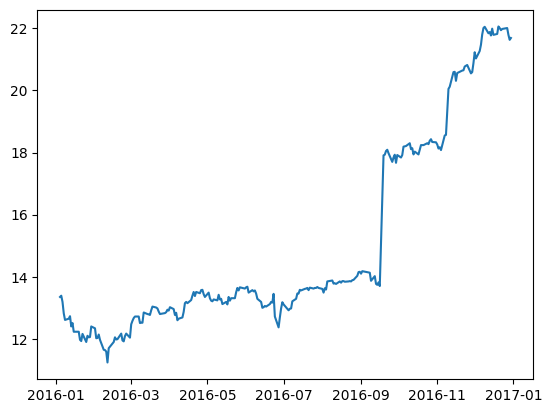

In [10]:
plt.plot(closing.XLF[closing.index.year == 2016])
plt.plot()
# Looks like data spikes around September/october
closing.XLF.loc['2016-09-01':'2016-11-01']

Now, check if the value is correct! Go to Yahoo Finance or any other source of your choice.
https://finance.yahoo.com/quote/XLF/history?period1=1472688000&period2=1474329600&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

<b>There was a stock split dividend on the these given dates. Price spike is justified & the data has passed the investigation. </b>

### Step 6: Checking for Stationarity

In the study of Time-Series Data, stationarity signifies independence of series characteristics over time. Simply explained, statistical properties of your data, can be assumed to be constant irrespective of the trend, seasonality etc during the time frame you pick a subset of your data from. This helps in choosing appropriate modelling techniques for your data.  

In [11]:
def check_stationarity(x):
    plt.title('Excess returns for '+x,fontdict={'fontsize':15})
    (c2cl[x].dropna()).plot(fontsize=15 , figsize=(18, 5), color = 'k')
    plt.show()
    adf=adfuller(c2cl[x].dropna())
    print('Adfuller Test Results:')
    c=0
    for i in ['Test Statistic: ','p Value: ','Number of Lags Used: ','Count of Observations used for the ADF & Critical Values Calculation: ','Critical Values: ']:
        print(i,adf[c])
        c+=1

In [12]:
adfuller(c2cl['XLB'])

(-18.78585177439405,
 2.0238465456237067e-30,
 17,
 5515,
 {'1%': -3.431536282195942,
  '5%': -2.8620642192277126,
  '10%': -2.5670490406778184},
 -30190.236902618366)

In [173]:
adfuller?

Tests for XLB :


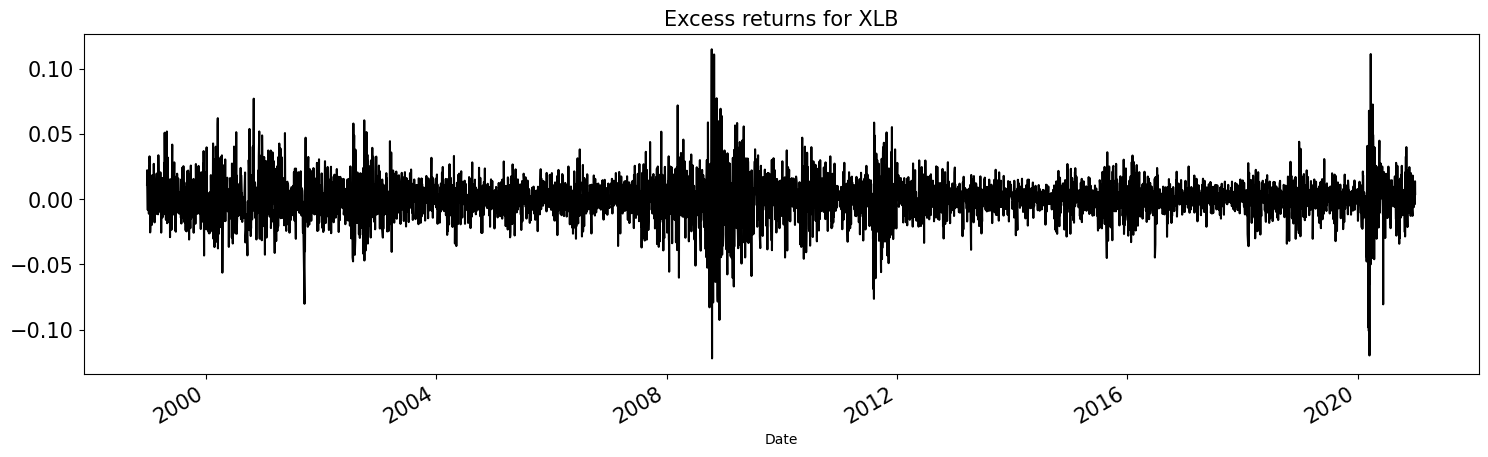

Adfuller Test Results:
Test Statistic:  -18.78585177439405
p Value:  2.0238465456237067e-30
Number of Lags Used:  17
Count of Observations used for the ADF & Critical Values Calculation:  5515
Critical Values:  {'1%': -3.431536282195942, '5%': -2.8620642192277126, '10%': -2.5670490406778184}

Tests for XLE :


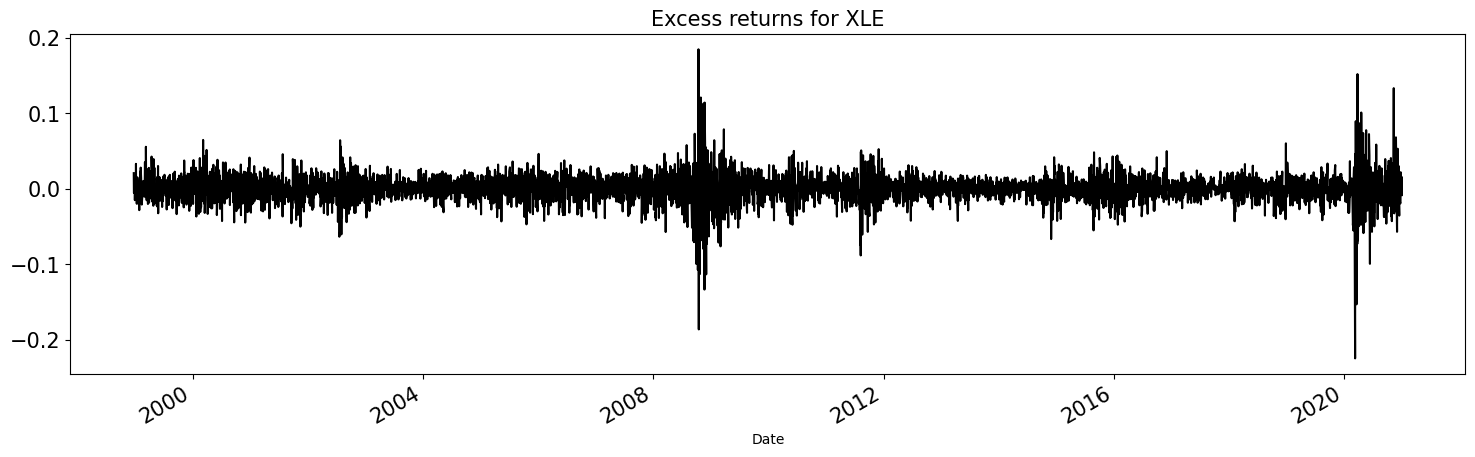

Adfuller Test Results:
Test Statistic:  -17.093552132953427
p Value:  7.56164854469535e-30
Number of Lags Used:  19
Count of Observations used for the ADF & Critical Values Calculation:  5513
Critical Values:  {'1%': -3.431536712754708, '5%': -2.862064409454073, '10%': -2.567049141941401}

Tests for XLF :


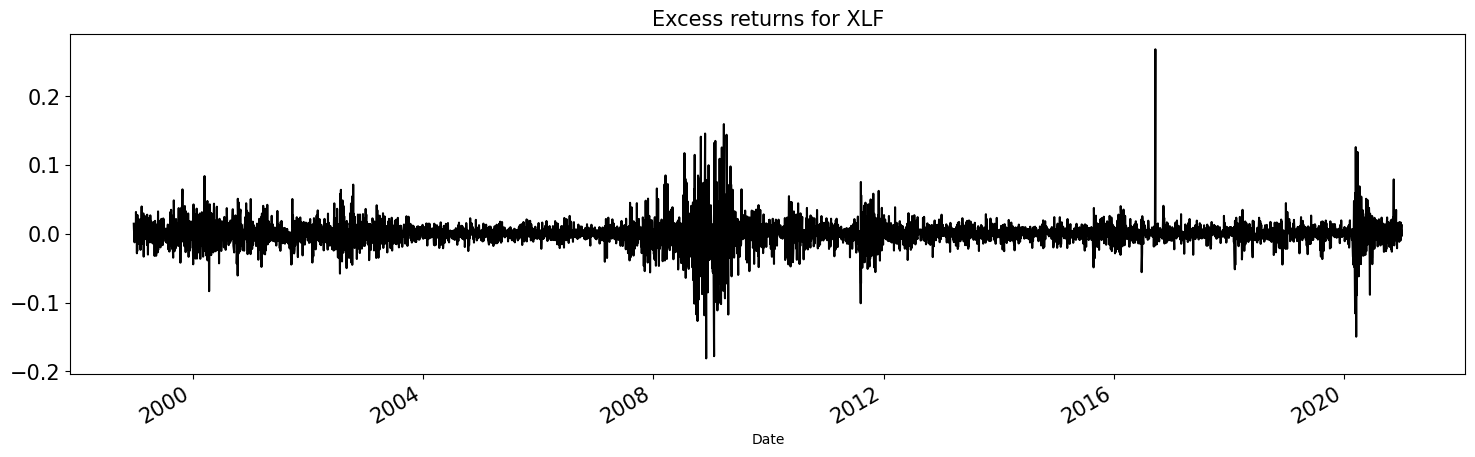

Adfuller Test Results:
Test Statistic:  -12.8349987712622
p Value:  5.765835862936101e-24
Number of Lags Used:  33
Count of Observations used for the ADF & Critical Values Calculation:  5499
Critical Values:  {'1%': -3.431539735439507, '5%': -2.862065744914038, '10%': -2.567049852849636}

Tests for XLI :


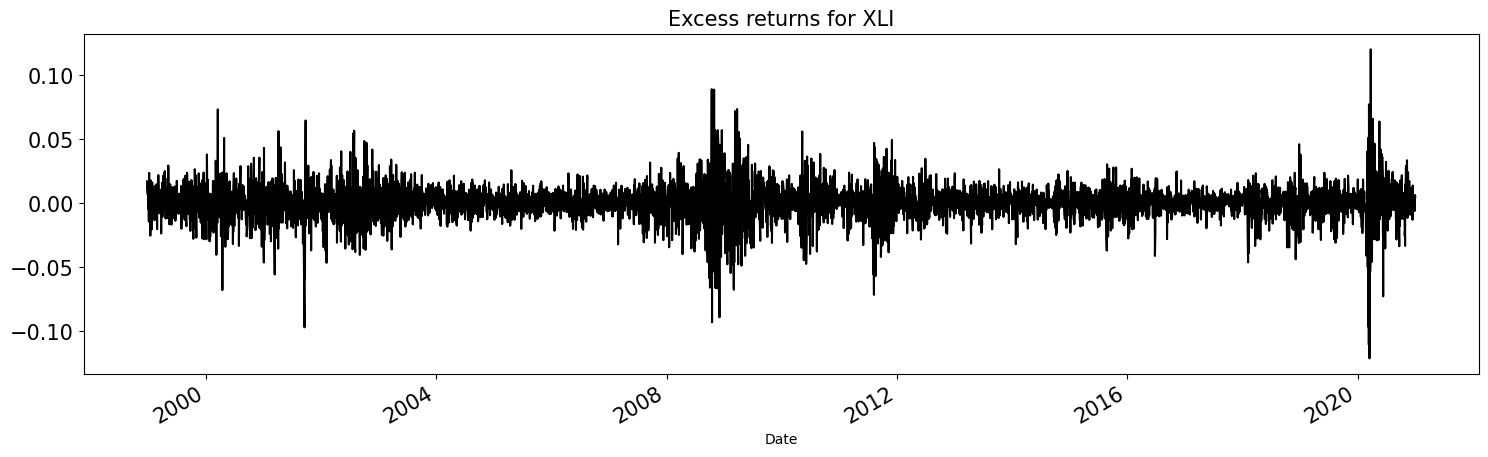

Adfuller Test Results:
Test Statistic:  -17.769903808372764
p Value:  3.310902780638759e-30
Number of Lags Used:  18
Count of Observations used for the ADF & Critical Values Calculation:  5514
Critical Values:  {'1%': -3.4315364974362645, '5%': -2.862064314323639, '10%': -2.5670490913004245}

Tests for XLK :


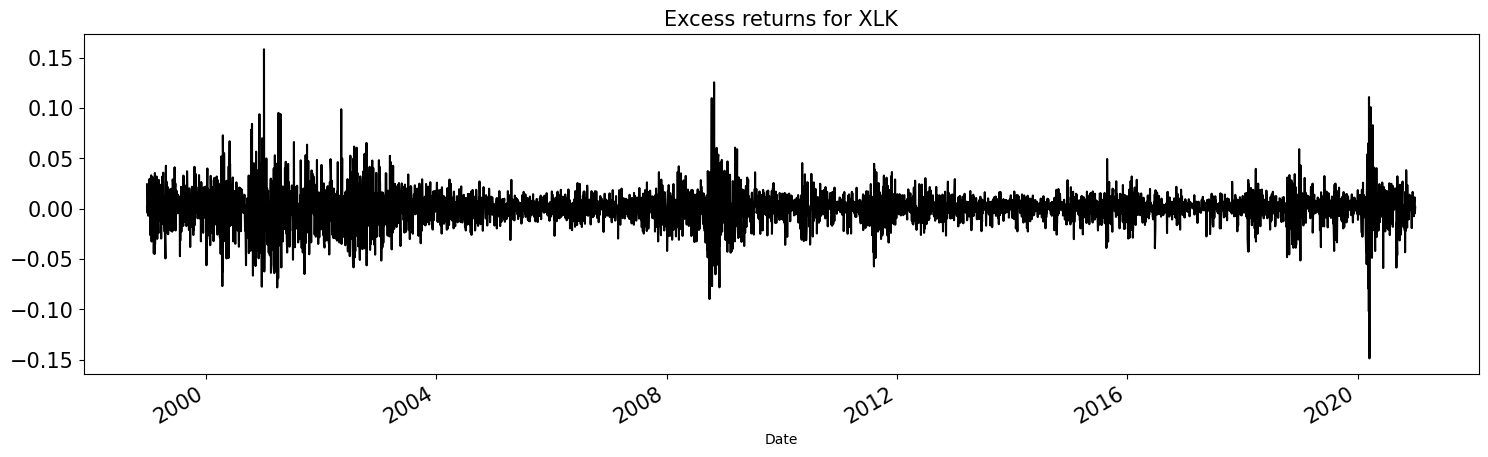

Adfuller Test Results:
Test Statistic:  -17.00965509794359
p Value:  8.609879548371562e-30
Number of Lags Used:  17
Count of Observations used for the ADF & Critical Values Calculation:  5515
Critical Values:  {'1%': -3.431536282195942, '5%': -2.8620642192277126, '10%': -2.5670490406778184}

Tests for XLP :


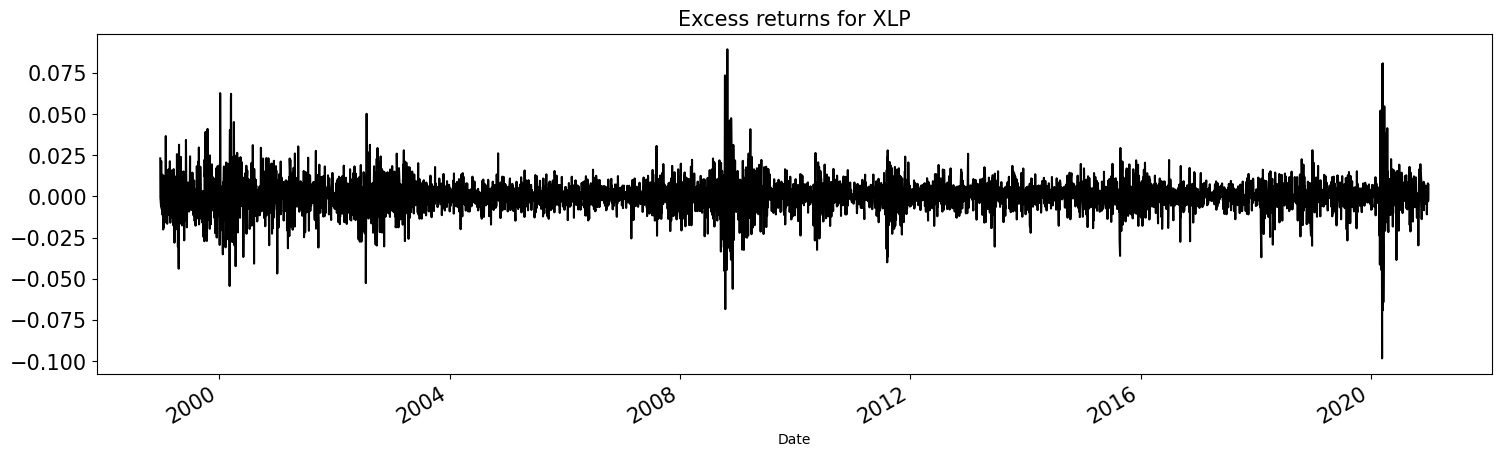

Adfuller Test Results:
Test Statistic:  -22.001368699411994
p Value:  0.0
Number of Lags Used:  11
Count of Observations used for the ADF & Critical Values Calculation:  5521
Critical Values:  {'1%': -3.4315349923921716, '5%': -2.862063649375773, '10%': -2.567048737327412}

Tests for XLU :


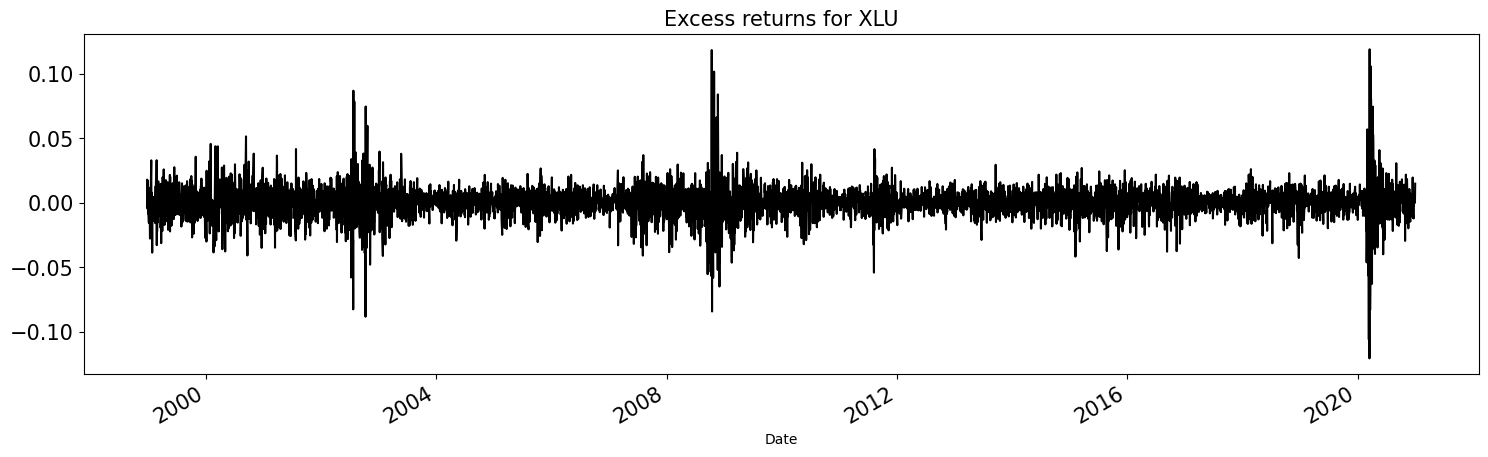

Adfuller Test Results:
Test Statistic:  -18.708062796306223
p Value:  2.0353563223654763e-30
Number of Lags Used:  15
Count of Observations used for the ADF & Critical Values Calculation:  5517
Critical Values:  {'1%': -3.4315358519494903, '5%': -2.8620640291393094, '10%': -2.567048939487679}

Tests for XLV :


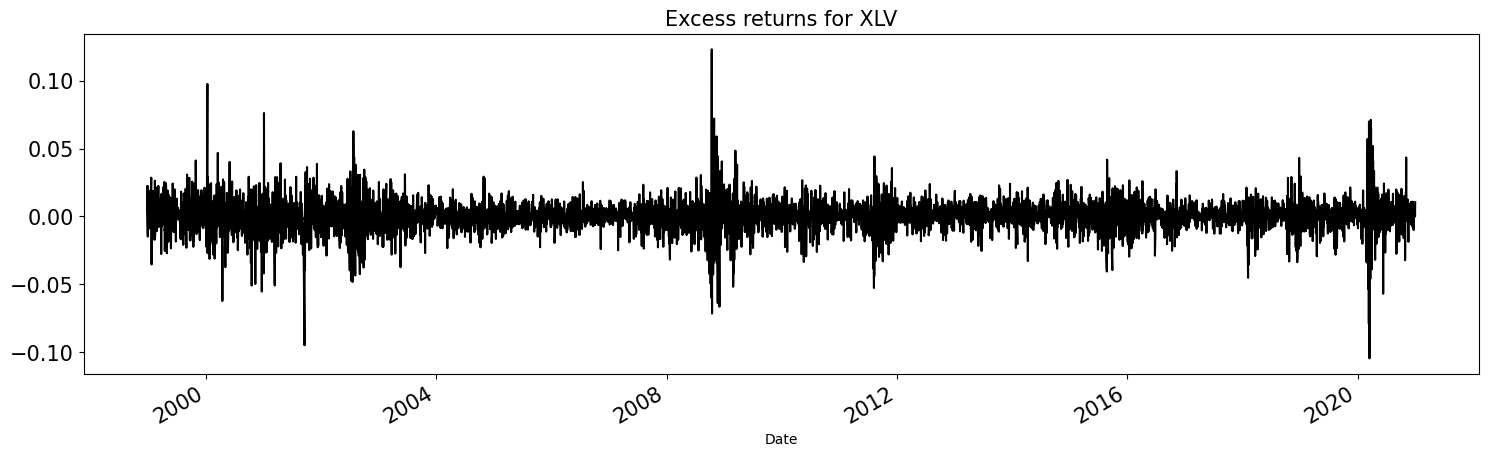

Adfuller Test Results:
Test Statistic:  -19.577053840897918
p Value:  0.0
Number of Lags Used:  15
Count of Observations used for the ADF & Critical Values Calculation:  5517
Critical Values:  {'1%': -3.4315358519494903, '5%': -2.8620640291393094, '10%': -2.567048939487679}

Tests for XLY :


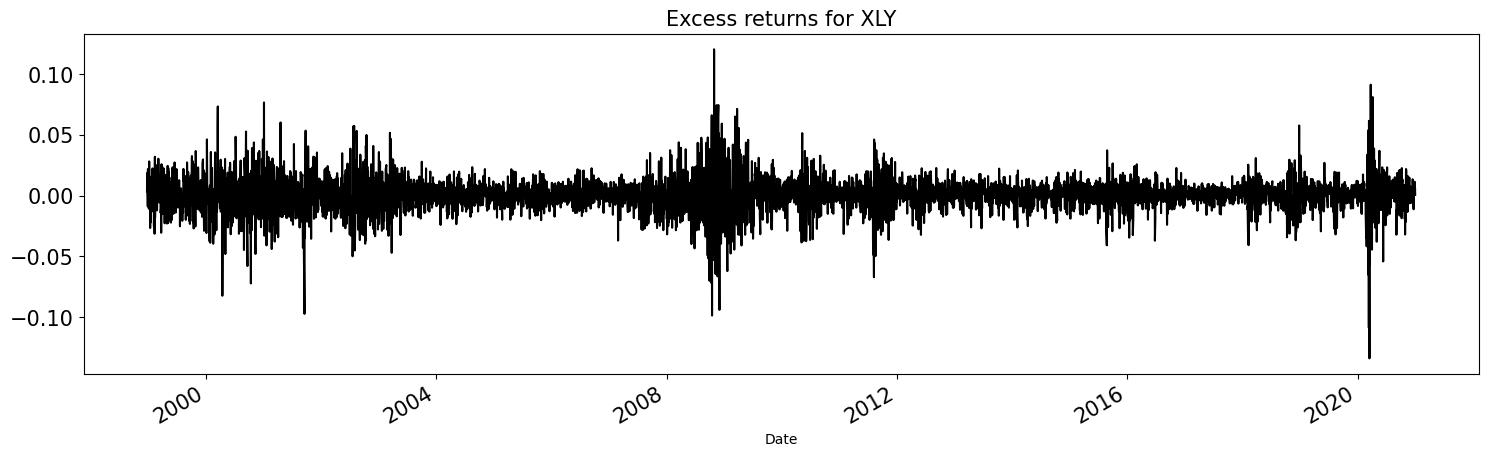

Adfuller Test Results:
Test Statistic:  -18.35192549423112
p Value:  2.235677997395396e-30
Number of Lags Used:  15
Count of Observations used for the ADF & Critical Values Calculation:  5517
Critical Values:  {'1%': -3.4315358519494903, '5%': -2.8620640291393094, '10%': -2.567048939487679}



In [13]:
for etf in ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']:
    print('Tests for', etf, ":")
    check_stationarity(etf)
    print()

### Step 7: Markov Regression

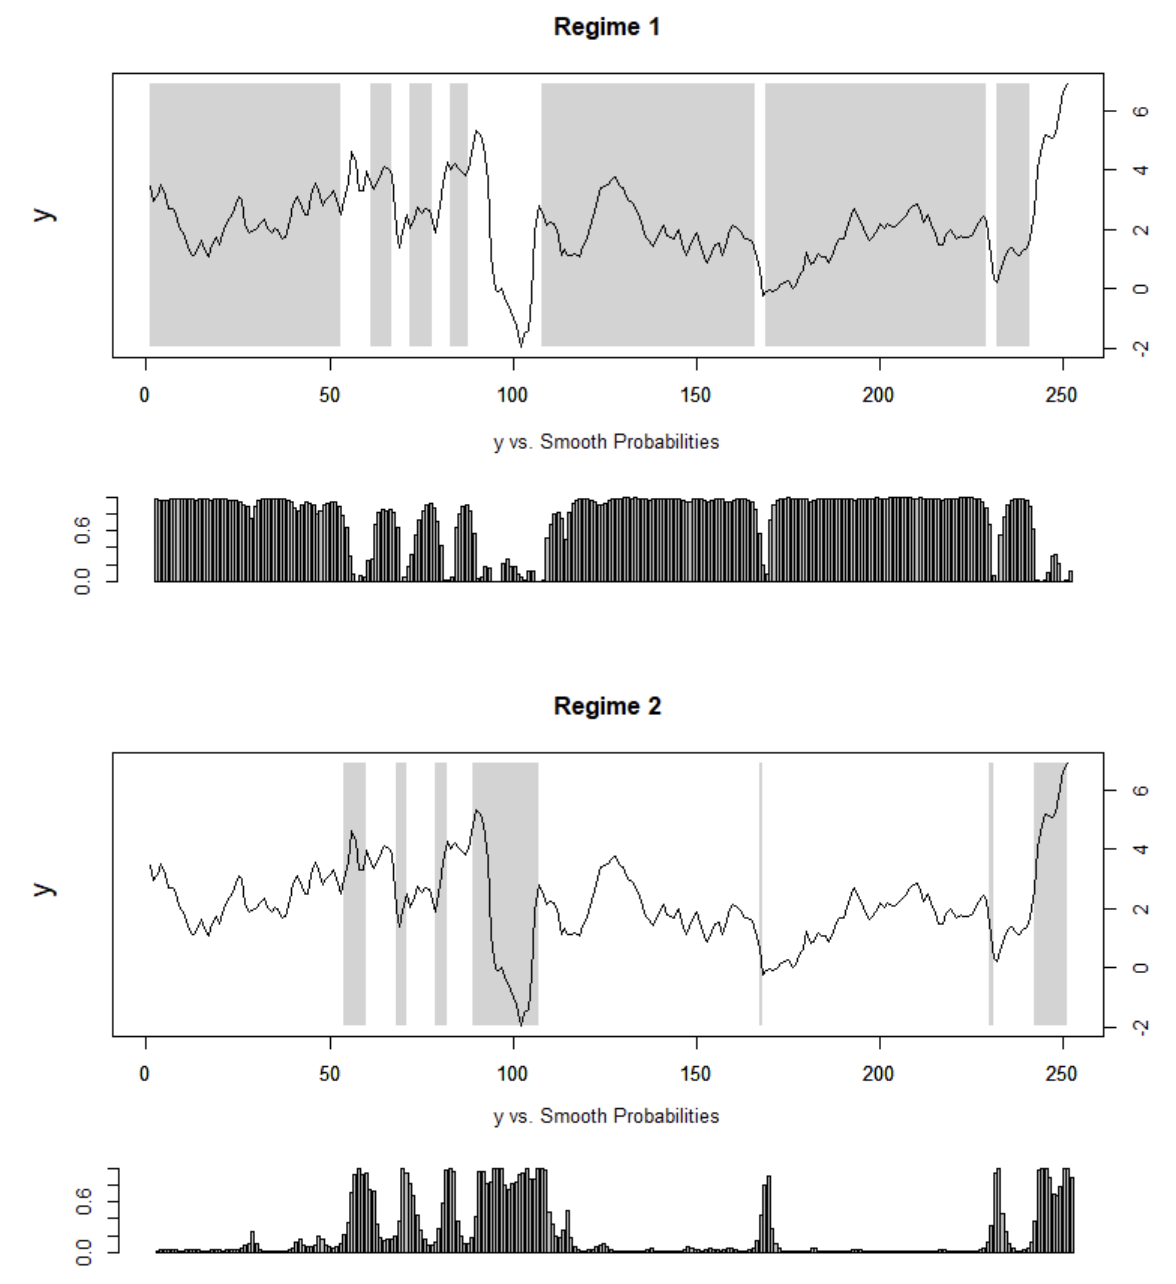
Reference: https://www.opb.org/article/2022/01/12/us-inflation-soared-7-in-past-year-the-most-since-1982/
<br>Graph taken from: https://www.r-bloggers.com/2022/02/understanding-hamilton-regime-switching-model-using-r-package/

In [175]:
sm.tsa.MarkovRegression?

In [14]:
# for printing graphs
def switching(res_kns, etf, yaxis):
    plt.figure(figsize=(17,3))
    plt.title(etf,fontdict={'fontsize':16},fontweight="bold")
    plt.plot(c2cl.index,res_kns.smoothed_marginal_probabilities[1],marker='o',color='k')
    plt.xticks(fontweight="bold",fontsize=15)
    plt.yticks(fontweight="bold",fontsize=15)
    plt.xlabel("Date",fontsize=15,fontweight="bold")
    plt.ylabel(yaxis,fontsize=15,fontweight="bold")
    plt.show()

In [15]:
# for application of step function
def changeToStep(array):
    arr=[]
    for i in array:
        if i>0.5:
            arr.append(1)
        else:
            arr.append(0)
    return arr

In [16]:
mod_kns = sm.tsa.MarkovRegression(c2cl['XLB'].dropna(), k_regimes=2, trend='c',switching_variance=True)
res_kns = mod_kns.fit()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [17]:
res_kns.smoothed_marginal_probabilities

,0,1
Date,,
1998-12-23,0.339242,0.660758
1998-12-24,0.309325,0.690675
1998-12-28,0.302647,0.697353
1998-12-29,0.284280,0.715720
1998-12-30,0.272405,0.727595
...,...,...
2020-12-24,0.998896,0.001104
2020-12-28,0.998181,0.001819
2020-12-29,0.996572,0.003428


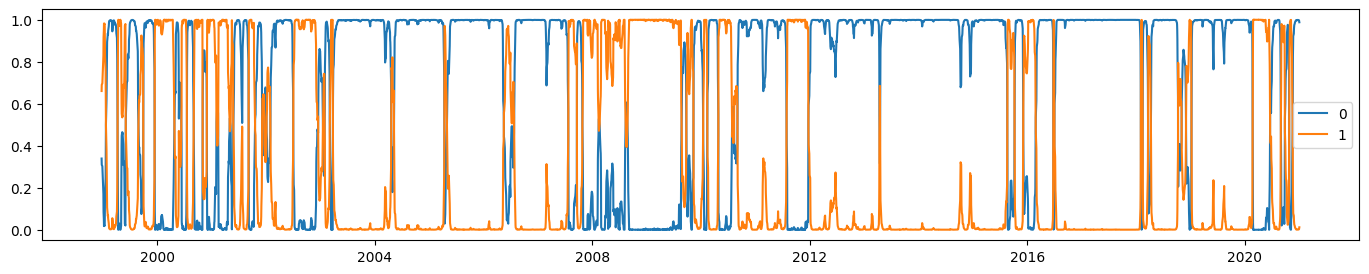

In [18]:
plt.figure(figsize=(17,3))
plt.plot(res_kns.smoothed_marginal_probabilities, label = res_kns.smoothed_marginal_probabilities.columns)
plt.legend()
plt.show()

In [19]:
def MerkovReg(x):
    mod_kns = sm.tsa.MarkovRegression(c2cl[x].dropna(), k_regimes=2, trend='c',switching_variance=True)
    res_kns = mod_kns.fit()
    print(res_kns.summary())
    switching(res_kns, x, "Smooth Probabilities") # function call
    res_kns.smoothed_marginal_probabilities[1]=changeToStep(res_kns.smoothed_marginal_probabilities[1]) # function call
    switching(res_kns, x,"Volatility States") # function call

Tests for XLB :


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                        Markov Switching Model Results                        
Dep. Variable:                    XLB   No. Observations:                 5533
Model:               MarkovRegression   Log Likelihood               16015.947
Date:                Mon, 05 Dec 2022   AIC                         -32019.894
Time:                        12:34:13   BIC                         -31980.183
Sample:                             0   HQIC                        -32006.047
                               - 5533                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000      4.746      0.000       0.000       0.001
sigma2      9.854e-05   3.71e-06     26.542      0.0

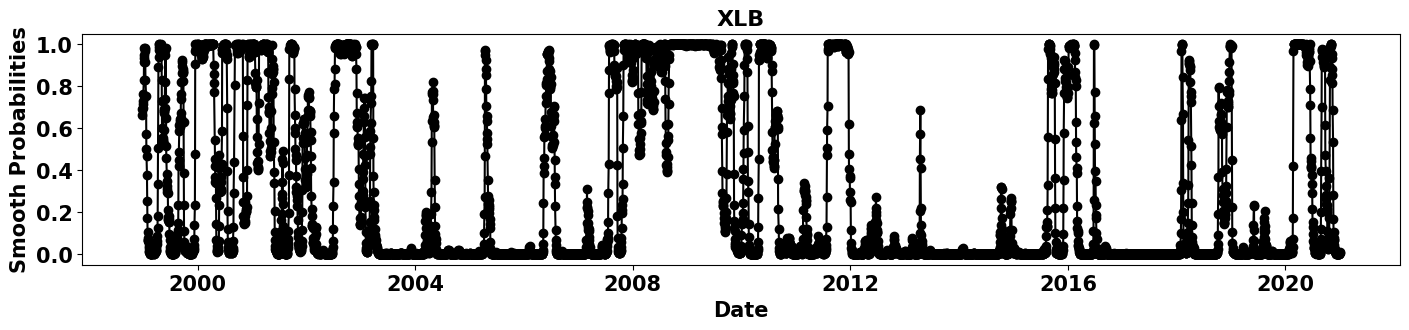

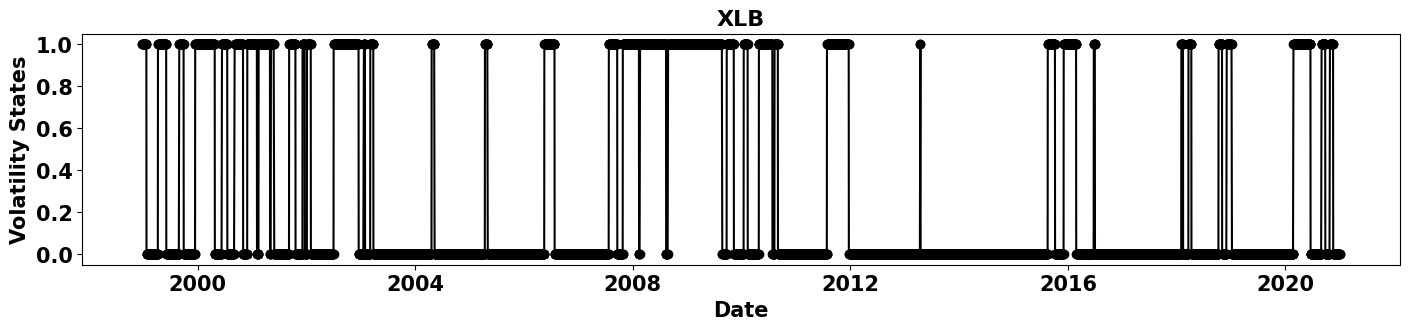


Tests for XLE :


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                        Markov Switching Model Results                        
Dep. Variable:                    XLE   No. Observations:                 5533
Model:               MarkovRegression   Log Likelihood               15196.773
Date:                Mon, 05 Dec 2022   AIC                         -30381.545
Time:                        12:34:13   BIC                         -30341.834
Sample:                             0   HQIC                        -30367.698
                               - 5533                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      3.054      0.002       0.000       0.001
sigma2         0.0002   5.04e-06     31.961      0.0

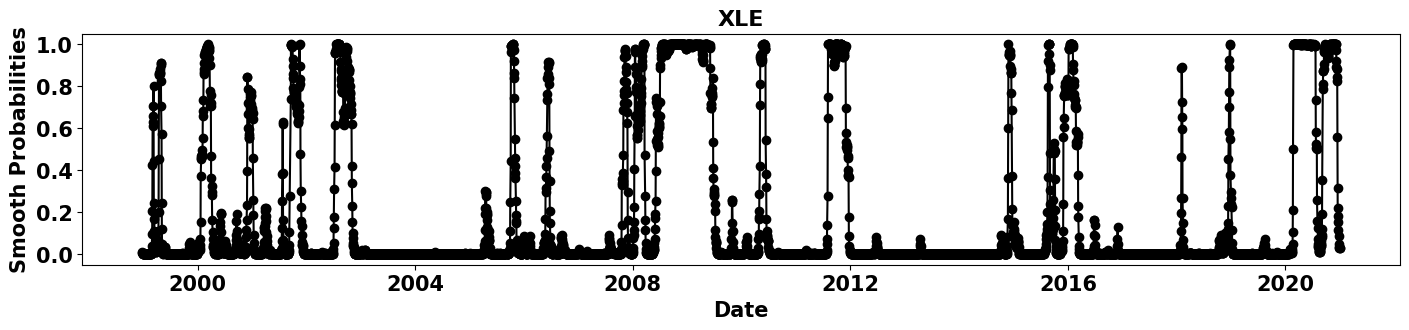

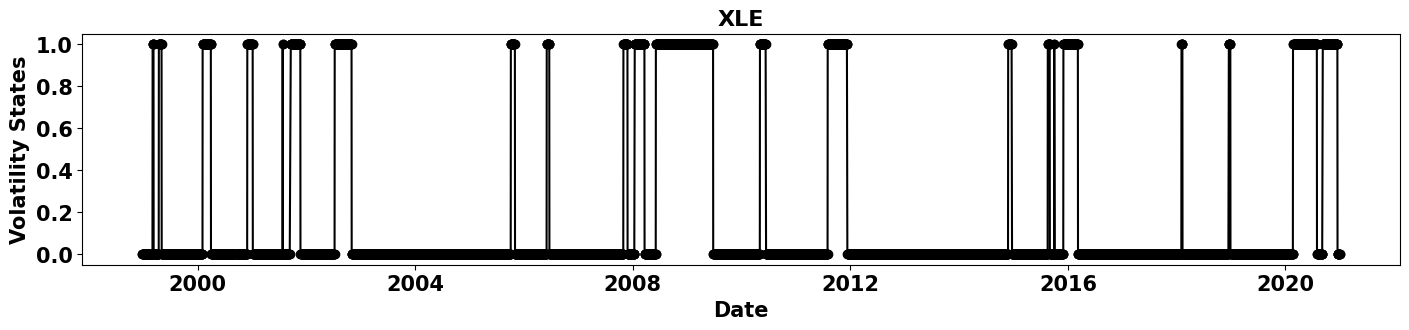


Tests for XLF :


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                        Markov Switching Model Results                        
Dep. Variable:                    XLF   No. Observations:                 5533
Model:               MarkovRegression   Log Likelihood               15750.980
Date:                Mon, 05 Dec 2022   AIC                         -31489.959
Time:                        12:34:14   BIC                         -31450.248
Sample:                             0   HQIC                        -31476.112
                               - 5533                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      3.755      0.000       0.000       0.001
sigma2      9.732e-05   3.41e-06     28.518      0.0

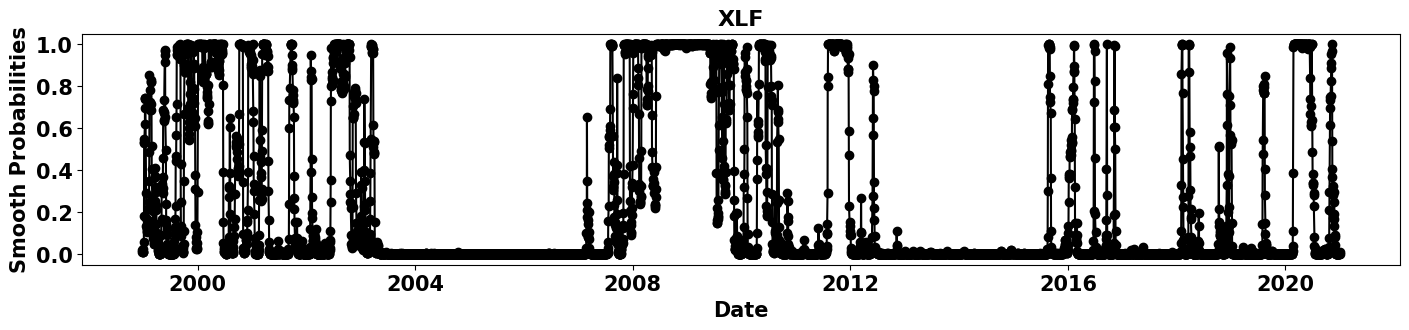

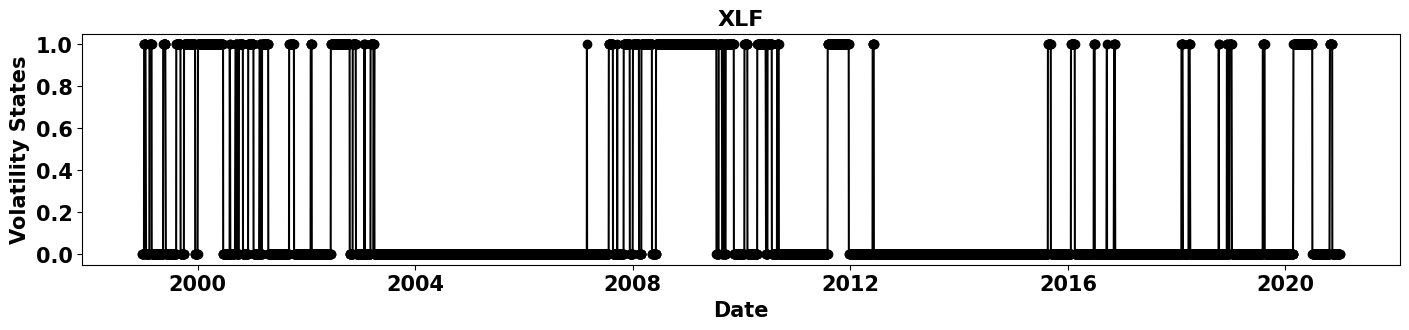


Tests for XLI :


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                        Markov Switching Model Results                        
Dep. Variable:                    XLI   No. Observations:                 5533
Model:               MarkovRegression   Log Likelihood               16795.833
Date:                Mon, 05 Dec 2022   AIC                         -33579.666
Time:                        12:34:15   BIC                         -33539.955
Sample:                             0   HQIC                        -33565.819
                               - 5533                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      6.216      0.000       0.001       0.001
sigma2      6.961e-05   2.38e-06     29.278      0.0

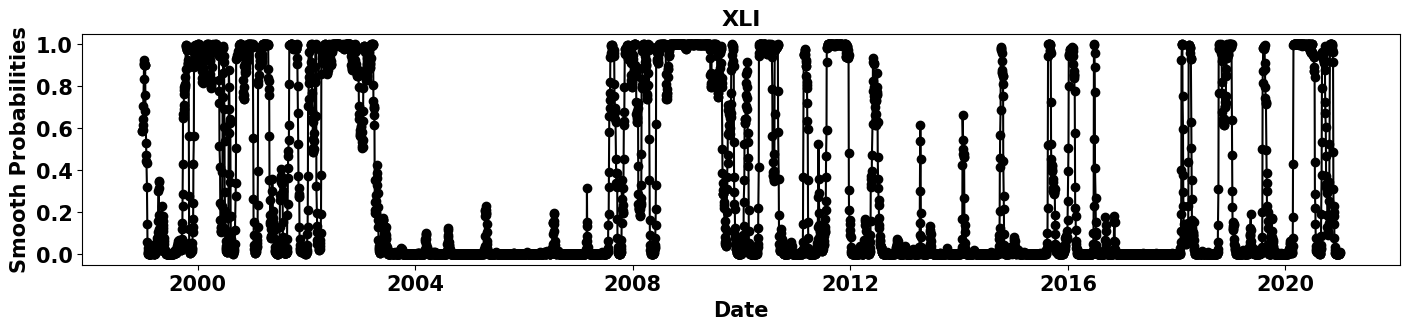

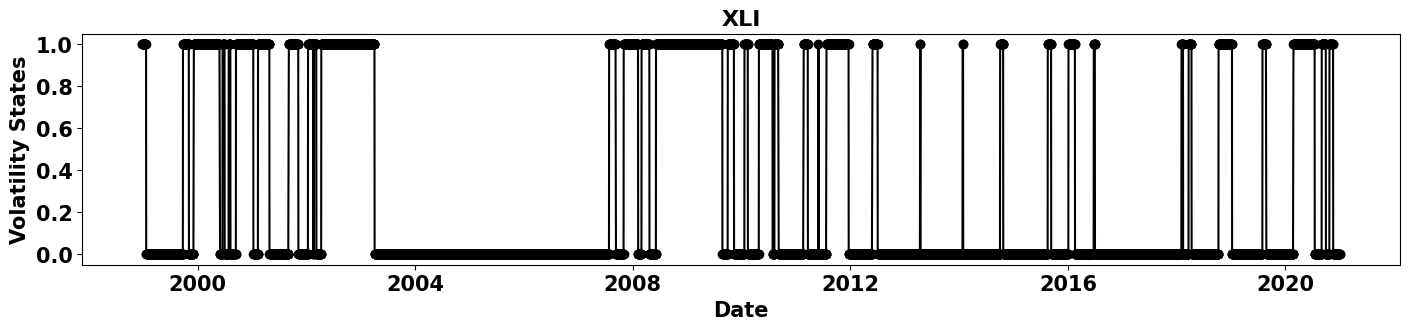


Tests for XLK :


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                        Markov Switching Model Results                        
Dep. Variable:                    XLK   No. Observations:                 5533
Model:               MarkovRegression   Log Likelihood               16131.264
Date:                Mon, 05 Dec 2022   AIC                         -32250.527
Time:                        12:34:16   BIC                         -32210.816
Sample:                             0   HQIC                        -32236.680
                               - 5533                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.000      6.594      0.000       0.001       0.001
sigma2      7.816e-05   2.44e-06     32.032      0.0

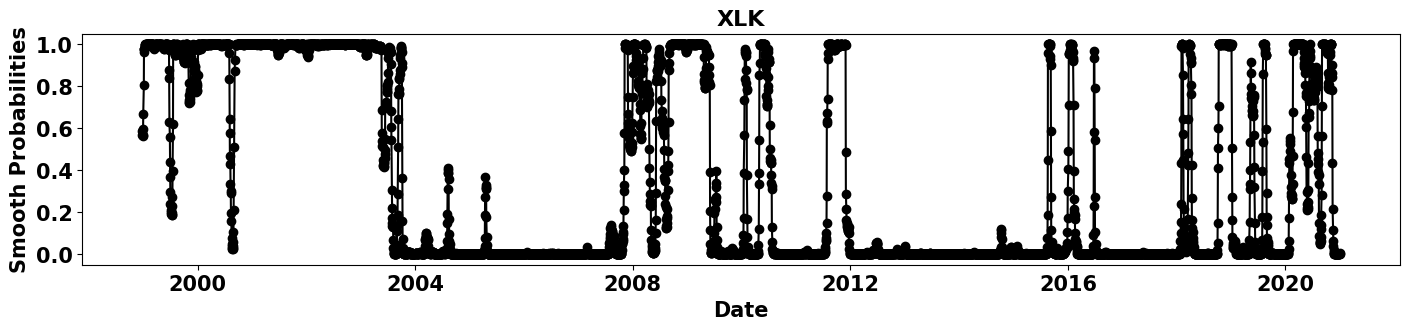

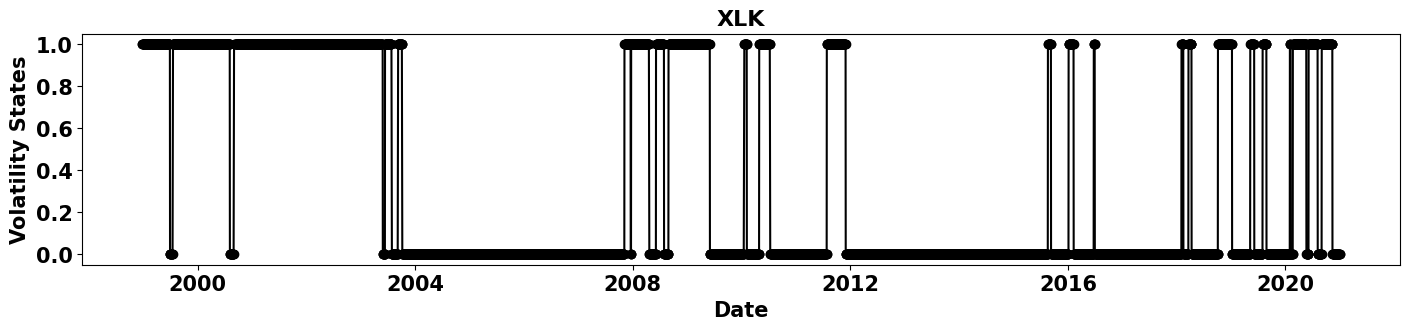


Tests for XLP :


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                        Markov Switching Model Results                        
Dep. Variable:                    XLP   No. Observations:                 5533
Model:               MarkovRegression   Log Likelihood               18627.559
Date:                Mon, 05 Dec 2022   AIC                         -37243.118
Time:                        12:34:17   BIC                         -37203.407
Sample:                             0   HQIC                        -37229.271
                               - 5533                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      5.922      0.000       0.000       0.001
sigma2      3.739e-05   1.24e-06     30.181      0.0

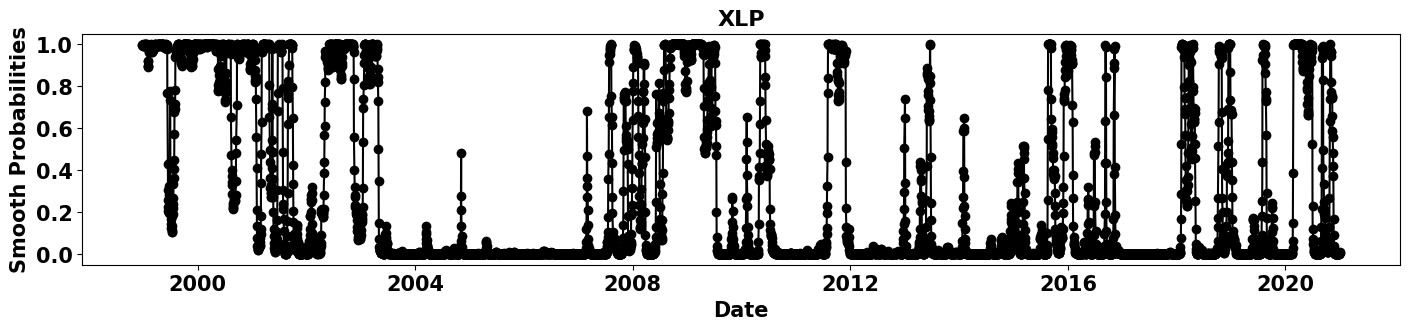

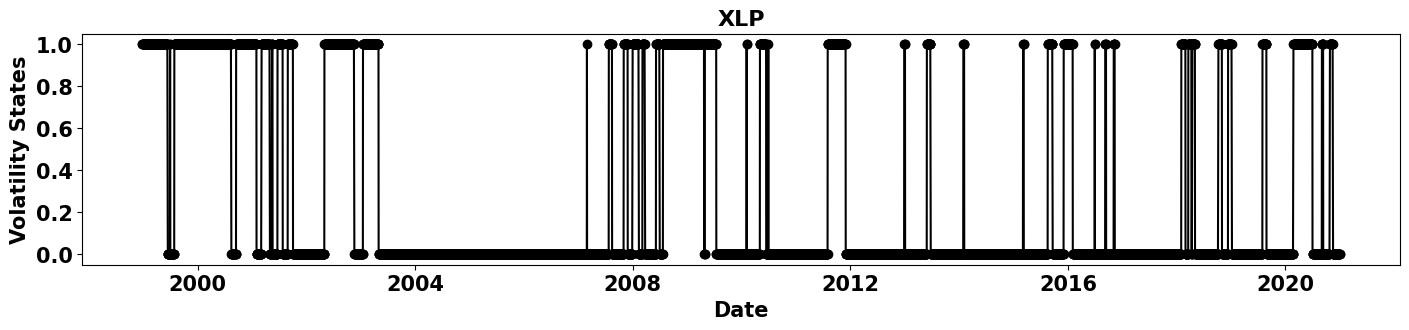


Tests for XLU :


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                        Markov Switching Model Results                        
Dep. Variable:                    XLU   No. Observations:                 5533
Model:               MarkovRegression   Log Likelihood               17413.372
Date:                Mon, 05 Dec 2022   AIC                         -34814.744
Time:                        12:34:17   BIC                         -34775.033
Sample:                             0   HQIC                        -34800.897
                               - 5533                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.000      5.539      0.000       0.000       0.001
sigma2       6.99e-05   2.12e-06     32.945      0.0

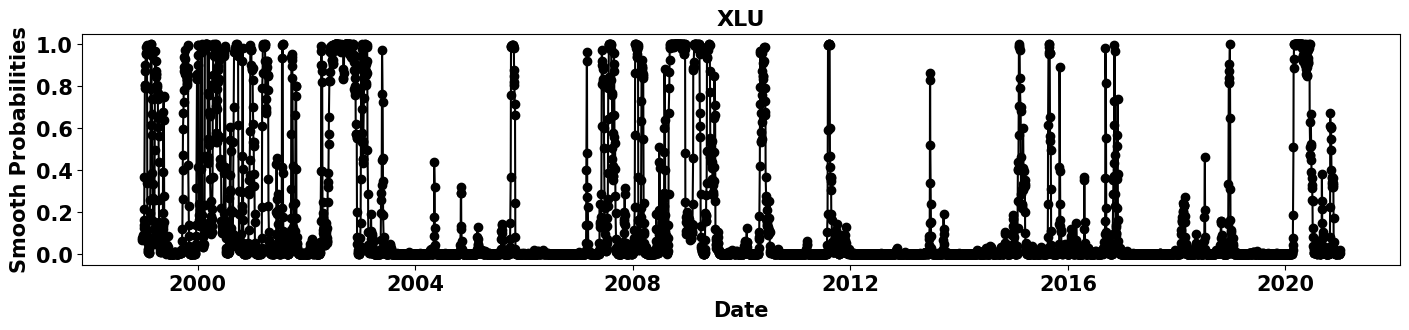

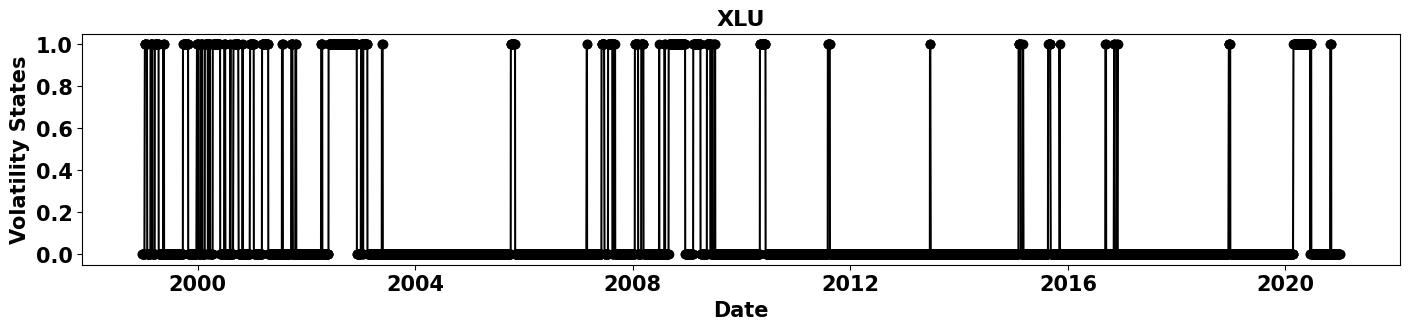


Tests for XLV :


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                        Markov Switching Model Results                        
Dep. Variable:                    XLV   No. Observations:                 5533
Model:               MarkovRegression   Log Likelihood               17578.262
Date:                Mon, 05 Dec 2022   AIC                         -35144.524
Time:                        12:34:18   BIC                         -35104.813
Sample:                             0   HQIC                        -35130.677
                               - 5533                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.000      5.160      0.000       0.000       0.001
sigma2      5.987e-05   2.02e-06     29.697      0.0

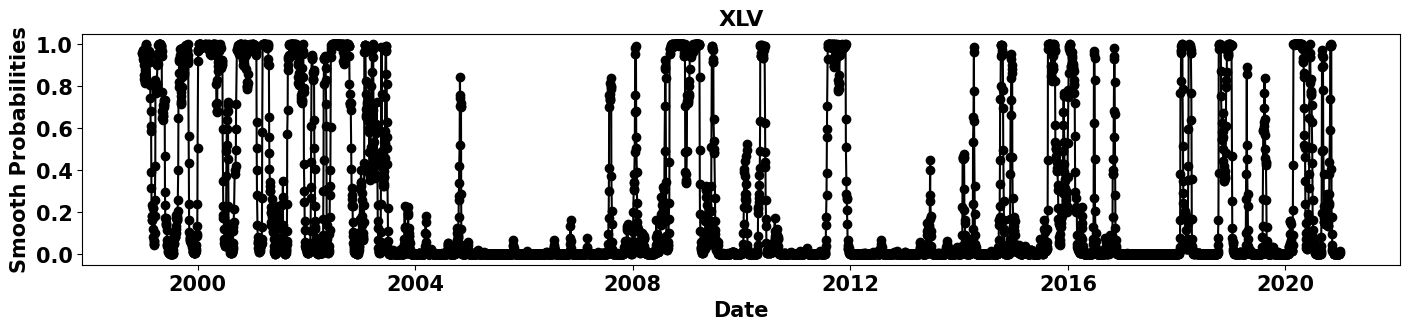

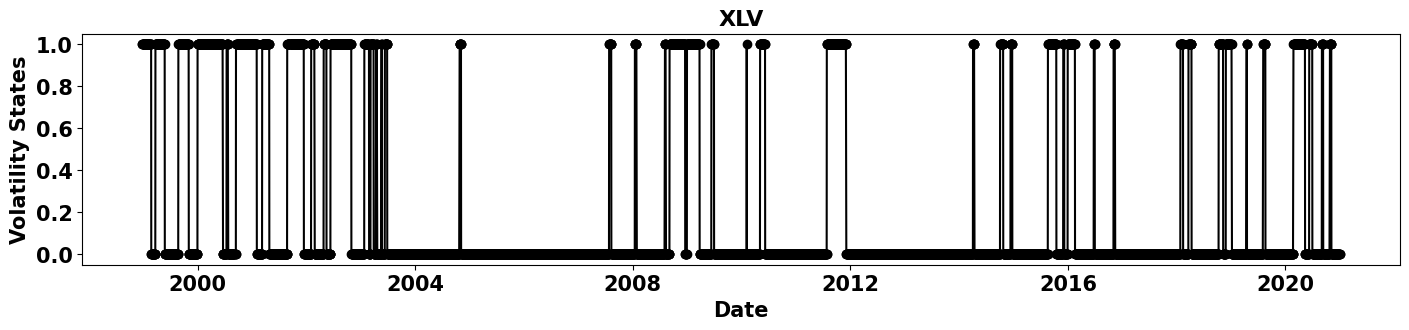


Tests for XLY :


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                        Markov Switching Model Results                        
Dep. Variable:                    XLY   No. Observations:                 5533
Model:               MarkovRegression   Log Likelihood               16779.661
Date:                Mon, 05 Dec 2022   AIC                         -33547.323
Time:                        12:34:19   BIC                         -33507.612
Sample:                             0   HQIC                        -33533.476
                               - 5533                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000      5.989      0.000       0.001       0.001
sigma2       6.15e-05   2.05e-06     30.060      0.0

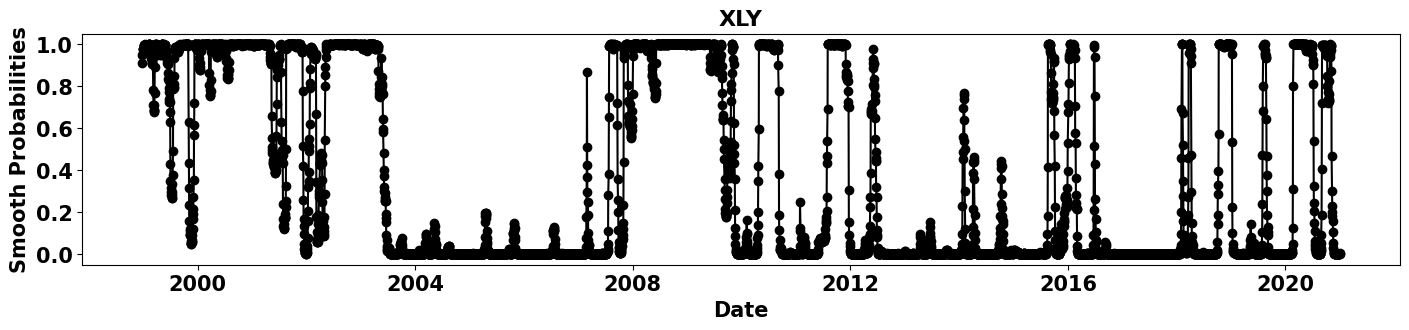

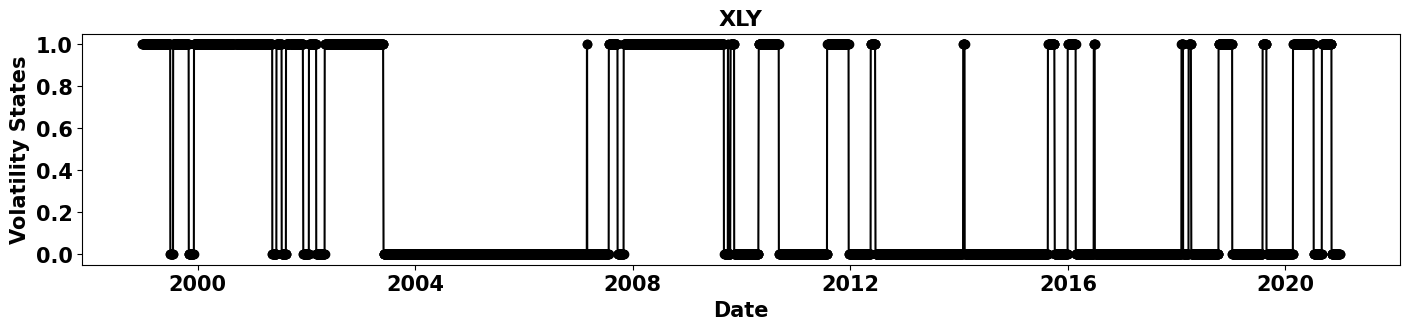

In [20]:
for etf in ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']:
    print('Tests for', etf, ":")
    MerkovReg(etf)
    print()

## Sklearn : Logistic Regression

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [22]:
df = pd.read_csv('ClassificationData.csv')
df

,probadj,XLB,VIXCLS,State
0,1,12.95,20.209999,1
1,1,13.24,21.480000,1
2,1,13.13,23.500000,1
3,1,13.37,22.180000,1
4,1,13.33,23.340000,1
...,...,...,...,...
5528,1,71.58,21.530000,0
5529,1,71.30,21.700000,0
5530,1,71.13,23.080000,0
5531,1,72.11,22.770000,0


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5533 entries, 0 to 5532
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   probadj  5533 non-null   int64  
 1   XLB      5533 non-null   float64
 2   VIXCLS   5533 non-null   float64
 3   State    5533 non-null   int64  
dtypes: float64(2), int64(2)
memory usage: 173.0 KB


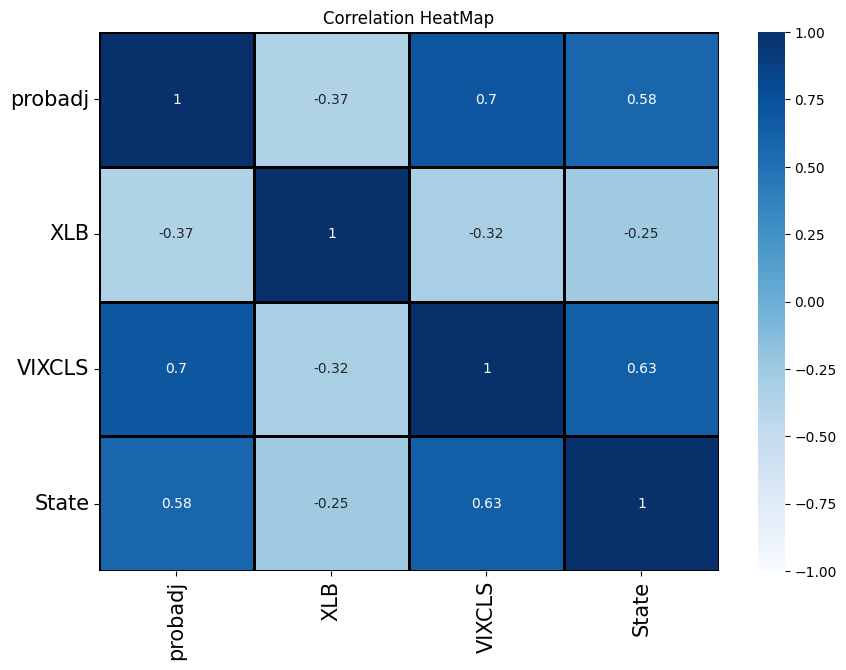

In [24]:
plt.figure(figsize=(10,7))
sns.heatmap(df.corr(),annot=True,cmap = 'Blues',vmin=-1,vmax=1,center=0,linewidths=2, linecolor='black')
plt.xticks(fontsize=15,rotation=90)
plt.yticks(fontsize=15,rotation=0)
plt.title('Correlation HeatMap')
plt.show()

In [25]:
d={'0':0,'1':1}
def diction(x):
    if x==0:
        d['0']+=1
    else:
        d['1']+=1
    return

In [26]:
df['State'].apply(diction)

0       None
1       None
2       None
3       None
4       None
        ... 
5528    None
5529    None
5530    None
5531    None
5532    None
Name: State, Length: 5533, dtype: object

In [27]:
d

{'0': 3930, '1': 1604}

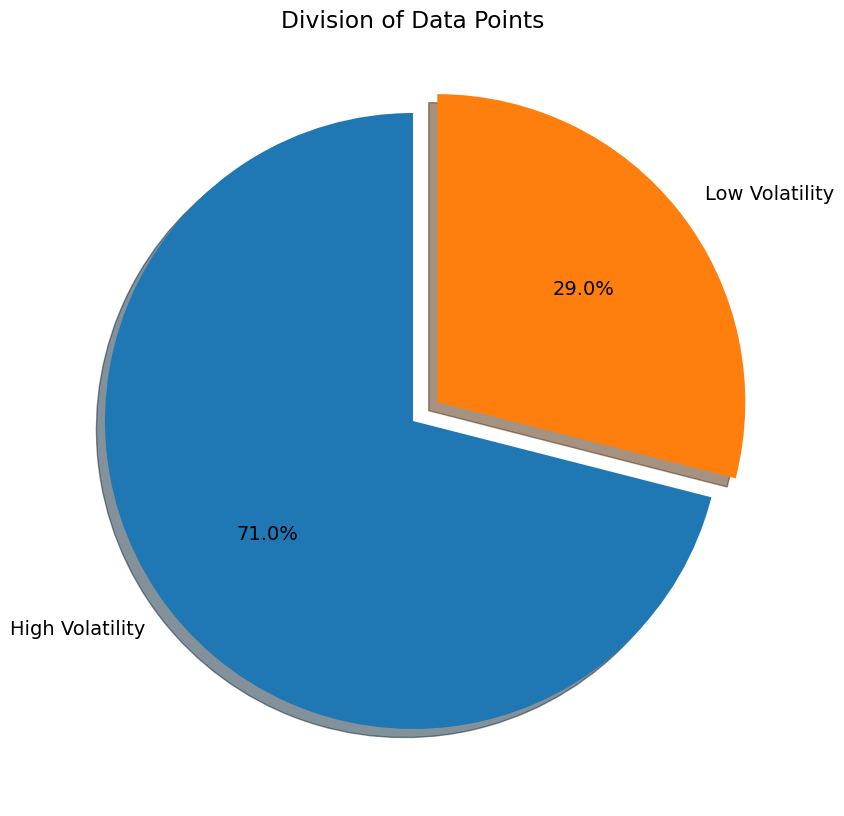

In [28]:
fig,ax=plt.subplots(figsize=(20,10))
plt.rcParams['font.size'] = 14.0
ax.pie(list(d.values()),labels=["High Volatility","Low Volatility"],startangle=90,autopct='%1.1f%%',explode=(0,0.1),shadow=True)
plt.title('Division of Data Points')
plt.show()

In [29]:
# Splitting our data into train & test
x_train,x_test,y_train,y_test = train_test_split(df[['XLB','VIXCLS','probadj']],df['State'],random_state=30,test_size=0.2)

In [30]:
classify=LogisticRegression()
classify=classify.fit(x_train,y_train)
print('Logistic Regression Train Score: ',classify.score(x_train, y_train))
print('Logistic Regression Test Score: ',classify.score(x_test, y_test))
print(classification_report(y_test,classify.predict(x_test)))

Logistic Regression Train Score:  0.841617713511071
Logistic Regression Test Score:  0.8437217705510388
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       773
           1       0.77      0.69      0.73       334

    accuracy                           0.84      1107
   macro avg       0.82      0.80      0.81      1107
weighted avg       0.84      0.84      0.84      1107



In [182]:
train_test_split?